# Grad-CAM - Sample High and low CN

## Loading IPA model

In [2]:
#!/usr/bin/env python
# coding: utf-8
import warnings
warnings.filterwarnings("ignore", "WARNING")

from scipy.io import loadmat
import numpy as np
from numpy.random import seed

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks", palette='muted')

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tqdm.keras import TqdmCallback

from python.architecture_tf import get_ipa_model
from python.plot_utils import *
from python.regression_utils import cnn_prediction

SEED_VALUE = 1
seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
tf.keras.utils.set_random_seed(SEED_VALUE)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Memory growth activated')

In [3]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [5]:
data = loadmat("data/raw-kennard-reduced_range.mat")

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
W = data['Wcal'][0]

scalerX = StandardScaler()
scalerY = StandardScaler()
X_train_scaled = scalerX.fit_transform(X_train)
X_test_scaled = scalerX.transform(X_test)
y_train_scaled = scalerY.fit_transform(y_train)
y_test_scaled = scalerY.transform(y_test)

X_train_reshaped = X_train_scaled[..., np.newaxis]
X_test_reshaped = X_test_scaled[..., np.newaxis]

""" REGULARIZATION HPs """
LEARNING_RATE = .001
REGULARIZATION_COEF = .0095
DROPOUT_RATE = .2

""" Base training HPs """
BATCH_SIZE = 16
EPOCHS = 500
MODEL_NAME = 'IPA-Keras'
path_model = 'model/'

Model does not exists, training in progress...




0epoch [00:00, ?epoch/s]



3/3 [==============================] - 0s 8ms/step
RMSEP: 0.114 - R2: 0.989 - Ratio: 1.021
RMSEC: 0.116
Scaled RMSEP 1.226


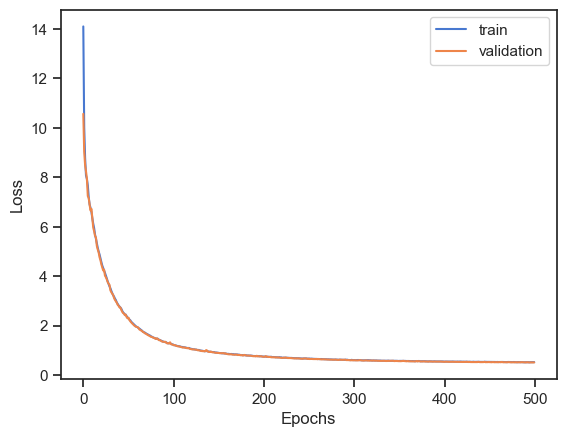

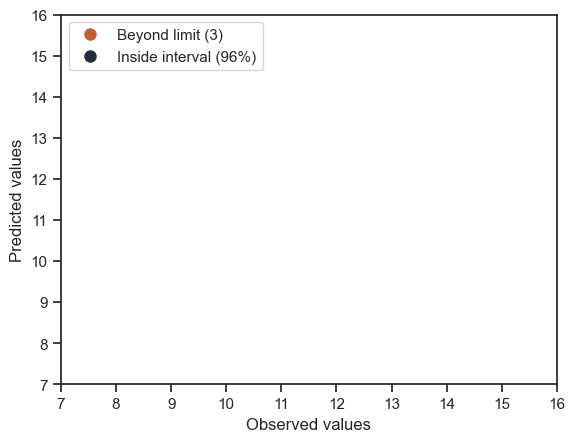

Saving model


C:\Users\haffnerf\.conda\envs\xai\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
if not os.path.exists(path_model + MODEL_NAME):
    print('Model does not exists, training in progress...')

    # Model input
    n_wavelength = X_train_reshaped.shape[1]
    fill_dimension = 1
    input_spectra = Input(shape=(n_wavelength, fill_dimension))

    model = get_ipa_model(input_spectra,
                          seed_value=SEED_VALUE,
                          regularization_factor=REGULARIZATION_COEF,
                          dropout_rate=DROPOUT_RATE,
                          model_name=MODEL_NAME)

    # Optimization parameters
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=10000, decay_rate=.001)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mse'])
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

    # Performing model training
    history = model.fit(
        X_train_reshaped, y_train_scaled,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test_reshaped, y_test_scaled),
        callbacks=[stop_early, TqdmCallback(verbose=0)],
        verbose=0,  # Suppress logging.
    )

    # Regression
    RMSEP, R2P, y_preds = cnn_prediction(model, scalerY,
                                         X_train_reshaped, X_test_reshaped,
                                         y_train_scaled, y_test_scaled)
    plot_history(history, RMSEP, R2P)
    plot_val(scalerY.inverse_transform(y_test_scaled), scalerY.inverse_transform(y_preds))

    print('Saving model')
    model.save(path_model + MODEL_NAME, overwrite=True, save_format='h5')


else:
    print('Model does exist, performing regression.')
    model = tf.keras.models.load_model(path_model + MODEL_NAME)

    # Regression
    _, _, y_preds = cnn_prediction(model, scalerY, X_train_reshaped, X_test_reshaped, y_train_scaled, y_test_scaled)
    plot_val(scalerY.inverse_transform(y_test_scaled), scalerY.inverse_transform(y_preds), 
             rmse_limit=2.8, axes=[10, 80])
    plot_err(scalerY.inverse_transform(y_test_scaled), scalerY.inverse_transform(y_preds), 
             deviation=5, n_count=20)


In [7]:
layer_outputs = [layer.output for layer in model.layers[:len(model.layers)]] # Filtering layers that matters
activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [8]:
first_idx_to_analyse = 28
second_idx_to_analyse = 34

In [9]:
spectra_outlier_low_cn = X_test_reshaped[[first_idx_to_analyse], :]
spectra_outlier_high_cn = X_test_reshaped[[second_idx_to_analyse], :]

print('Nombre de couches/resultats dans le réseau: '+str(len(model.layers)))
i_layer=0
i_spectre=0
activations_high_cn = activation_model.predict(spectra_outlier_high_cn)
activations_low_cn = activation_model.predict(spectra_outlier_low_cn)

Nombre de couches/resultats dans le réseau: 17
1/1 [==============================] - 0s 15ms/step


In [10]:
layer_names = []
for layer in model.layers[:len(model.layers)]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    i_layer=i_layer+1
    layer_activation=activations_high_cn[i_layer-1]
    if layer.name in ['conv1d_2', 'conv1d_5', 'conv1d_6', 'conv1d_9', 'conv1d_8']:
        print(str(i_layer)+' '+layer.name+' '+str(layer_activation.shape))
i_layer=0

4 conv1d_2 (1, 1940, 32)
9 conv1d_9 (1, 241, 64)
10 conv1d_5 (1, 485, 64)
11 conv1d_6 (1, 968, 64)
13 conv1d_8 (1, 970, 64)


## Function definition

In [11]:
import numpy as np
from scipy import interpolate

def interpolate_array(arr: np.ndarray, new_shape: tuple):
    """
    Interpolates a numpy array using scipy's interp1d function.

    Parameters:
    arr (ndarray): The input numpy array with shape (1, N).
    new_shape (tuple): The desired new shape of the array in the form (1, M).

    Returns:
    ndarray: The interpolated numpy array with shape new_shape.
    """
    old_shape = arr.shape
    assert len(old_shape) == 2 and old_shape[0] == 1, "Input array should have shape (1, N)"
    assert len(new_shape) == 2 and new_shape[0] == 1, "New shape should be (1, M)"

    old_size = old_shape[1]
    new_size = new_shape[1]

    x = np.linspace(0, 1, old_size)
    x_new = np.linspace(0, 1, new_size)
    f = interpolate.interp1d(x, arr[0], kind='linear', bounds_error=False, fill_value="extrapolate")
    interpolated_arr = f(x_new)
    return interpolated_arr.reshape(new_shape)

In [12]:
from matplotlib.ticker import ScalarFormatter

def multiplot_activation(df, spectrum, ax1, title, last_fig=False):
    ax1.set(ylim=(-.5, 1.))
    ax2 = ax1.twinx()
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    if last_fig:
        ax1.set(xlabel='Wavenumbers (cm-1)', ylabel='Absorbance')
    else:
        ax1.xaxis.set_ticklabels([])
        ax1.set(xlabel='', ylabel='Absorbance')
    
    # Create a colorbar to show the mapping of y values to colors
    cmap = plt.get_cmap('turbo')
    normalize = plt.Normalize(vmin=np.min(df), vmax=np.max(df))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    cbar = plt.colorbar(sm, ax=ax1, orientation='vertical', format='%.5f', pad=0.025)
    
    # Set colorbar tick positions and labels
    cbar_ticks = np.linspace(np.min(df), np.max(df), 5)
    cbar_labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_labels)
    cbar.set_label('CAM activation')

    # Line for important chemical species for given property - [450,4750] for aromatics | [5300,6000] for aliphatics
    plt.plot([4500, 4500], [np.min(spectrum), np.max(spectrum)], linestyle='--', color='gray')
    plt.plot([4750, 4750], [np.min(spectrum), np.max(spectrum)], linestyle='--', color='gray')
    plt.plot([5300, 5300], [np.min(spectrum), np.max(spectrum)], linestyle='--', color='gray')
    plt.plot([6000, 6000], [np.min(spectrum), np.max(spectrum)], linestyle='--', color='gray')
    plt.text(4500, np.max(spectrum), '4500', rotation=45)
    plt.text(4750, np.max(spectrum), '4750', rotation=45)
    plt.text(5300, np.max(spectrum), '5300', rotation=45)
    plt.text(6000, np.max(spectrum), '6000', rotation=45)
    
    sns.scatterplot(y=spectrum, x=W, c=df, linewidth=0, cmap=cmap, ax=ax1)
    plt.title(title)

In [13]:
def utils_np_to_df(array, wavenumbers, index_name):
    df = pd.DataFrame(array)
    df.columns = wavenumbers
    df.index = [index_name]
    return df

## Grad-CAM lineplot analysis of a low CN

In [14]:
key_to_idx = {
    'stem1': {'idx': 1},
    'stem2': {'idx': 2},
    'stem3': {'idx': 4},
    'branch1': {'idx': 10},
    'branch2': {'idx': 11},
    'branch3': {'idx': 9},
    'branch4': {'idx': 13}
}

stem = list(key_to_idx.keys())[:3]
branches = list(key_to_idx.keys())[3:]

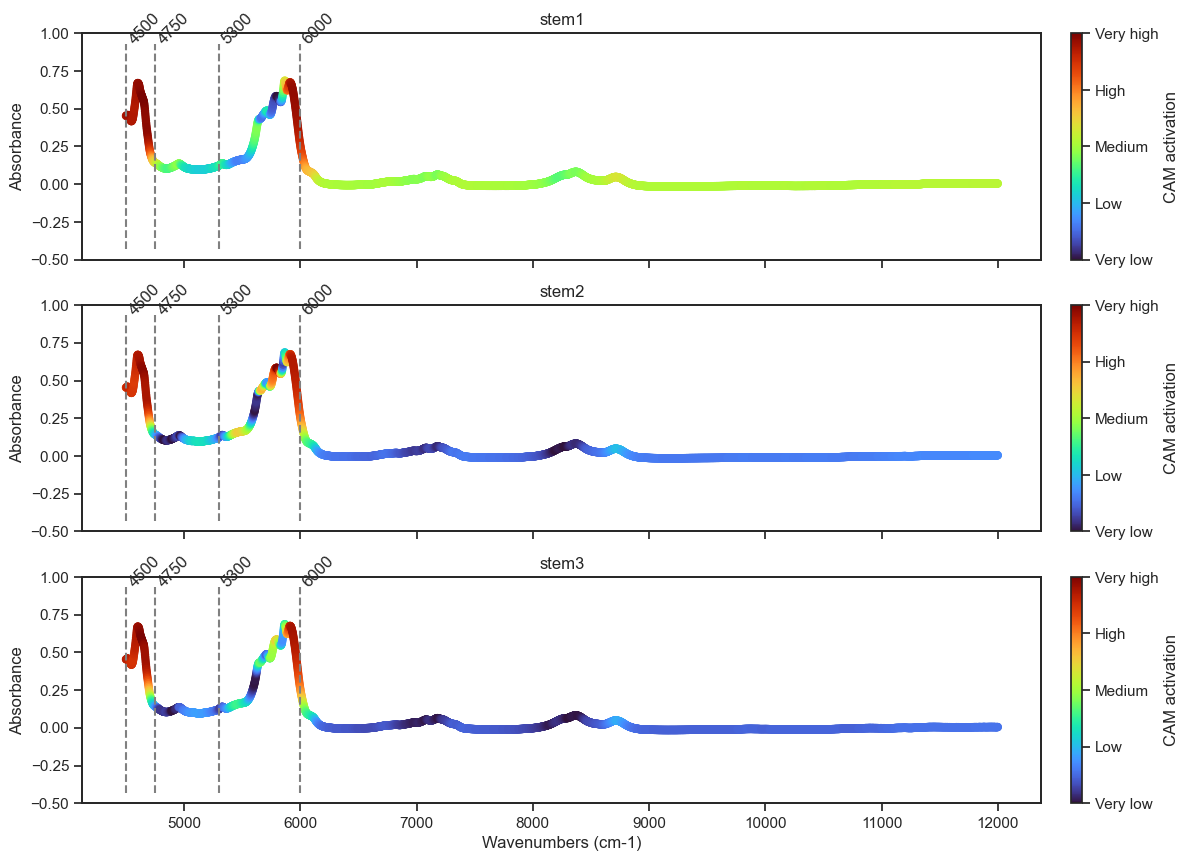

In [15]:
cam_activations = []
selected_activations = activations_low_cn
selected_spectrum = X_test[[first_idx_to_analyse],:][-1,:]

for key in stem:
    idx = key_to_idx[key]['idx']
    gap = GlobalAveragePooling1D(data_format='channels_first')(selected_activations[idx-1])
    interpolated_spectra = interpolate_array(gap, X_train[np.newaxis,0].shape)
    cam_activations.append(interpolated_spectra)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,10))
multiplot_activation(cam_activations[0][-1,:], selected_spectrum, ax1, 'stem1')
multiplot_activation(cam_activations[1][-1,:], selected_spectrum, ax2, 'stem2')
multiplot_activation(cam_activations[2][-1,:], selected_spectrum, ax3, 'stem3', last_fig=True)

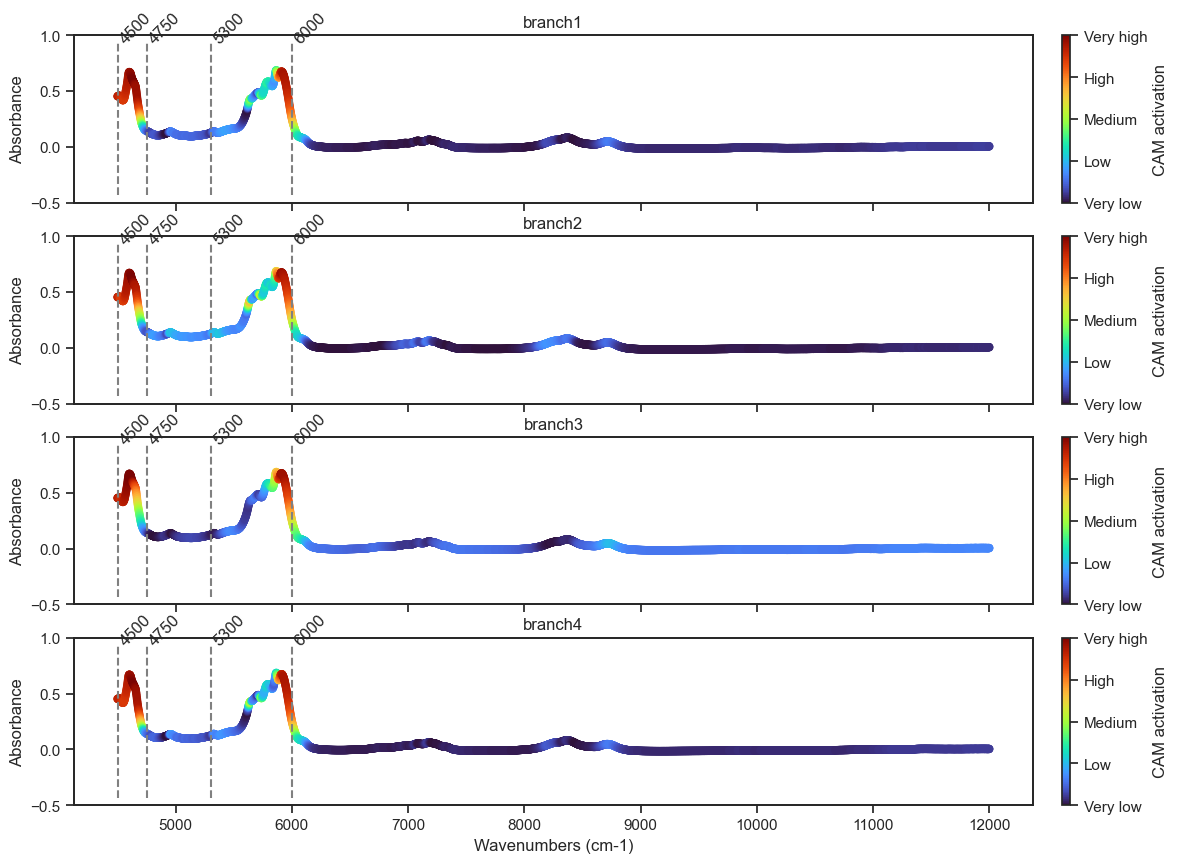

In [16]:
cam_activations = []
selected_activations = activations_low_cn
selected_spectrum = X_test[[first_idx_to_analyse],:][-1,:]

for key in branches:
    idx = key_to_idx[key]['idx']
    gap = GlobalAveragePooling1D(data_format='channels_first')(selected_activations[idx-1])
    interpolated_spectra = interpolate_array(gap, X_train[np.newaxis,0].shape)
    cam_activations.append(interpolated_spectra)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,10))
multiplot_activation(cam_activations[0][-1,:], selected_spectrum, ax1, 'branch1')
multiplot_activation(cam_activations[1][-1,:], selected_spectrum, ax2, 'branch2')
multiplot_activation(cam_activations[2][-1,:], selected_spectrum, ax3, 'branch3')
multiplot_activation(cam_activations[3][-1,:], selected_spectrum, ax4, 'branch4', last_fig=True)